<a href="https://colab.research.google.com/github/0ginny/TIL/blob/main/240406_RNN_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### google drive

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Part 3 - Recurrent Neural Networks

/content/gdrive/MyDrive/Colab Notebooks/Part 3 - Recurrent Neural Networks


# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [5]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values # to make numpy 'array' --> only array applied in deaplearning model

In [6]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Feature Scaling

Stansdardisation 과 Normalisation 이 있어.

정규화가 조금 더 난 거 같대, 왜?? sklearn의 최소 최대 척도 클래스를 쓸거래

RNN 을 쓸 때 sigmoid 함수가 활성화 함수로 쓰이면 정규화가 더 좋대.

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1) ) # 데이터의 척도
training_set_scaled = sc.fit_transform(training_set) # scaling apply

### Creating a data structure with 60 timesteps and 1 output

예측할 때 60 step 전까지 타임스텝을 관여하겠다는 의미

트렌드를 확인할 수 있는 최적의 스텝을 찾는 건 그냥 시행착오

저자가 실험했을 대는 60타임이 가장 의미있었음.

In [8]:
# 입력 출력 초기화
x_train = []
y_train = []

# 기본적으로 60 타임으로 하려면, 기존에 60개의 데이터 가 있어야해.
for i in range(60, training_set.shape[0]) :
    x_train.append(training_set_scaled[i-60:i, 0]) # 60개 이전의 데이터를 배열로 append
    y_train.append(training_set_scaled[i, 0]) # T +1을 예측하는 것이기 때문에
x_train, y_train = np.array(x_train), np.array(y_train)


In [9]:
pd.DataFrame(y_train)

,0
0,0.086279
1,0.084716
2,0.074541
3,0.078838
4,0.072383
...,...
1193,0.952043
1194,0.951633
1195,0.957251
1196,0.937960


### Reshaping

In [10]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1)) # Keras RNN 에 적용 가능한 배열 형태로 만들어줘. (batch_size, timesteps, input_dim (예측변수의 수))
x_train

array([[[0.08581368],
        [0.09701243],
        [0.09433366],
        ...,
        [0.07846566],
        [0.08034452],
        [0.08497656]],

       [[0.09701243],
        [0.09433366],
        [0.09156187],
        ...,
        [0.08034452],
        [0.08497656],
        [0.08627874]],

       [[0.09433366],
        [0.09156187],
        [0.07984225],
        ...,
        [0.08497656],
        [0.08627874],
        [0.08471612]],

       ...,

       [[0.92106928],
        [0.92438053],
        [0.93048218],
        ...,
        [0.95475854],
        [0.95204256],
        [0.95163331]],

       [[0.92438053],
        [0.93048218],
        [0.9299055 ],
        ...,
        [0.95204256],
        [0.95163331],
        [0.95725128]],

       [[0.93048218],
        [0.9299055 ],
        [0.93113327],
        ...,
        [0.95163331],
        [0.95725128],
        [0.93796041]]])

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

### Initialising the RNN

In [12]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [13]:
# Drop out 과적합을 피하기 위해.
# LSTM에 작성할 파라미터 3, LSTL 에 쓰일 인수의 숫자, 다음에 LST 층을 만들 것인지 (bool), input_shape 이전에 reshape 하면서 작성한 수
regressor.add(LSTM(units = 50, # 누련의 수
                   return_sequences = True, # 다음에 층을 추가할 것인지?
                   input_shape =(x_train.shape[1], 1) ))

In [14]:
regressor.add(Dropout(0.2)) # 20%의 뉴련을 무시(drop out)

### Adding a second LSTM layer and some Dropout regularisation

In [15]:
# inputshap는 맨 처음 입력에 맞춰서 자동으로 입력됨.
regressor.add(LSTM(units = 50,
                   return_sequences = True) )
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [16]:
regressor.add(LSTM(units = 50,
                   return_sequences = True) )
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [17]:
regressor.add(LSTM(units = 50) ) # 마지막 LSTM Layer 이라
regressor.add(Dropout(0.2))

### Adding the output layer

In [18]:
# for full connection, using Dense layer
regressor.add(Dense(units = 1))

### Compiling the RNN

In [19]:
regressor.compile(optimizer = 'adam', # RNN 을 위해선 RMSprop 도 잘 쓰여.
                  loss = 'mean_squared_error') # 회귀에선 MSE가 손실함수로 많이 쓰여.

### Fitting the RNN to the Training set

In [20]:
regressor.fit(x = x_train,
              y = y_train,
              epochs = 100, # 데이터가 적으므로 100개 정도가 적당했대
              batch_size= 32)

Epoch 1/100
38/38 [==============================] - 9s 16ms/step - loss: 0.0373
Epoch 2/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0072
Epoch 3/100
38/38 [==============================] - 1s 19ms/step - loss: 0.0056
Epoch 4/100
38/38 [==============================] - 1s 18ms/step - loss: 0.0060
Epoch 5/100
38/38 [==============================] - 1s 19ms/step - loss: 0.0049
Epoch 6/100
38/38 [==============================] - 1s 19ms/step - loss: 0.0059
Epoch 7/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0050
Epoch 8/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0048
Epoch 9/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0043
Epoch 10/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0043
Epoch 11/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0041
Epoch 12/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0041
Epoch 13/100
38/38 [=====

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [21]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2017

In [22]:
# 무엇을 넣어줘야 할까?

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis =0) # 수직적 연결 0, 수평적 연결 1

#
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)

inputs = sc.transform(inputs)

In [23]:
dataset_test.shape

(20, 6)

In [24]:
# 입력 출력 초기화
x_test = []

# 기본적으로 60 타임으로 하려면, 기존에 60개의 데이터 가 있어야해.
for i in range(60, 60+dataset_test.shape[0]) :
    x_test.append(inputs[i-60:i, 0]) # 60개 이전의 데이터를 배열로 append
x_test= np.array(x_test)


In [25]:
# 3d format
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1)) # Keras RNN 에 적용 가능한 배열 형태로 만들어줘. (batch_size, timesteps, input_dim (예측변수의 수))


In [26]:
# predict
predicted_stock_price = regressor.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [27]:
# 역스케일링
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualising the results

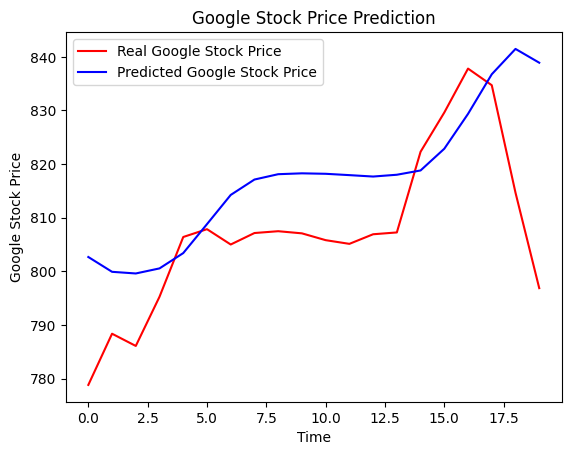

In [28]:
plt.plot(real_stock_price, color = 'red', label= 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label= 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()